In [2]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
def download_data(ticker, start_date="2014-01-01"):
    # download ticker data from yfinance library
    df = yf.download(ticker, start=start_date)
    df.dropna(inplace=True)
    return df

# Download data
ticker1 = "KO"
ticker2 = "PEP"
df_ko = download_data(ticker1)
df_pep = download_data(ticker2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df_ko.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,41.119999,41.230000,40.509998,40.660000,29.140585,12698600
2014-01-03,40.680000,40.730000,40.349998,40.459999,28.997250,10403400
2014-01-06,40.480000,40.590000,40.160000,40.270000,28.861073,11036300
2014-01-07,40.480000,40.720001,40.290001,40.389999,28.947073,11872300
2014-01-08,40.439999,40.439999,39.830002,39.939999,28.624559,15339600


In [5]:
df_pep.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,82.930000,82.989998,81.820000,82.099998,60.635120,3275900
2014-01-03,82.120003,82.870003,82.120003,82.239998,60.738518,3287200
2014-01-06,82.199997,82.610001,82.080002,82.279999,60.768040,3888400
2014-01-07,82.620003,83.989998,82.610001,83.480003,61.654308,6332400
2014-01-08,83.330002,83.620003,82.809998,83.239998,61.477055,5653300


In [6]:
def prepare_time_series(data1, data2, label1, label2, normalize):
    # combine both time series from data1 and data2 into a new pandas dataframe
    data = pd.concat([data1['Close'], data2['Close']], axis=1).dropna()
    data.columns = [label1, label2]
    if normalize:
        data = data / data.iloc[0]  # normalize prices
    return data

data = prepare_time_series(df_ko, df_pep, ticker1, ticker2, normalize=False)
data.head()

,KO,PEP
Date,,
2014-01-02,40.660000,82.099998
2014-01-03,40.459999,82.239998
2014-01-06,40.270000,82.279999
2014-01-07,40.389999,83.480003
2014-01-08,39.939999,83.239998


# Engle-Granger method: Cointegration analysis between time series

## Step 1: Residual anaylsis between price time series $X_t, Y_t$


1. **Linear regression of $X_t$ onto $Y_t$ to describe long-term equilibrium relationship**:

The regression equation is: $$Y_t = \beta_0 + \beta_1 X_t + u_t$$ where $u_t$ is the residual.


2. **ADF Test on Residuals:**

It follows from the regression equation that $$u_t = Y_t - \beta_0 - \beta_1 X_t.$$ If $X_t$ and $Y_t$ are cointegrated, then the residuals $u_t$ must be stationary. To find out whether a time series is stationary, we conduct the *Augmented Dickey-Fuller (ADF) test* to check for stationarity of $u_t$.

The *ADF test* checks for unit roots in time series. The null hypothesis is that the tested time series $u_t$ has a unit root and is therefore non-stationary. If the p-value is below a certain significant value (e.g. 5% or 1%), we reject the null hypothesis, indicating that the series is stationary.

In [7]:
def least_squares_regression(y, X):
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # add y-intercept to X
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)  # least sqaures regression into coefficient vector beta

    # calculate residuals
    y_pred = X @ beta
    residuals = y - y_pred
    return beta, residuals


# Perform ordinary least square (OLS) regression
y = data[ticker1].values
X = data[ticker2].values.reshape(-1, 1)
beta, residuals = least_squares_regression(y, X)
data['residuals'] = residuals
data.head()

,KO,PEP,residuals
Date,,,
2014-01-02,40.660000,82.099998,2.556351
2014-01-03,40.459999,82.239998,2.321934
2014-01-06,40.270000,82.279999,2.122102
2014-01-07,40.389999,83.480003,1.947102
2014-01-08,39.939999,83.239998,1.556102


In [8]:
beta  # i.e. KO_t = beta[0] + beta[1] * PEP_t + u_t

array([17.92085625,  0.24583182])

In our case, writing $\beta = \left(\beta_0, \beta_1\right) \approx \left(17.9, 0.25\right)$, the linear regression yields the following relationship between the time series of KO and PEP: $$\text{KO}_t = \beta_0 + \beta_1 \text{PEP}_t + u_t,$$ where $u_t$ denotes the time series of residuals in the dataframe, also shown here:

In [9]:
data['residuals']

Date
2014-01-02    2.556351
2014-01-03    2.321934
2014-01-06    2.122102
2014-01-07    1.947102
2014-01-08    1.556102
                ...   
2024-08-01    7.028405
2024-08-02    7.641249
2024-08-05    7.394573
2024-08-06    7.725614
2024-08-07    8.307695
Name: residuals, Length: 2667, dtype: float64

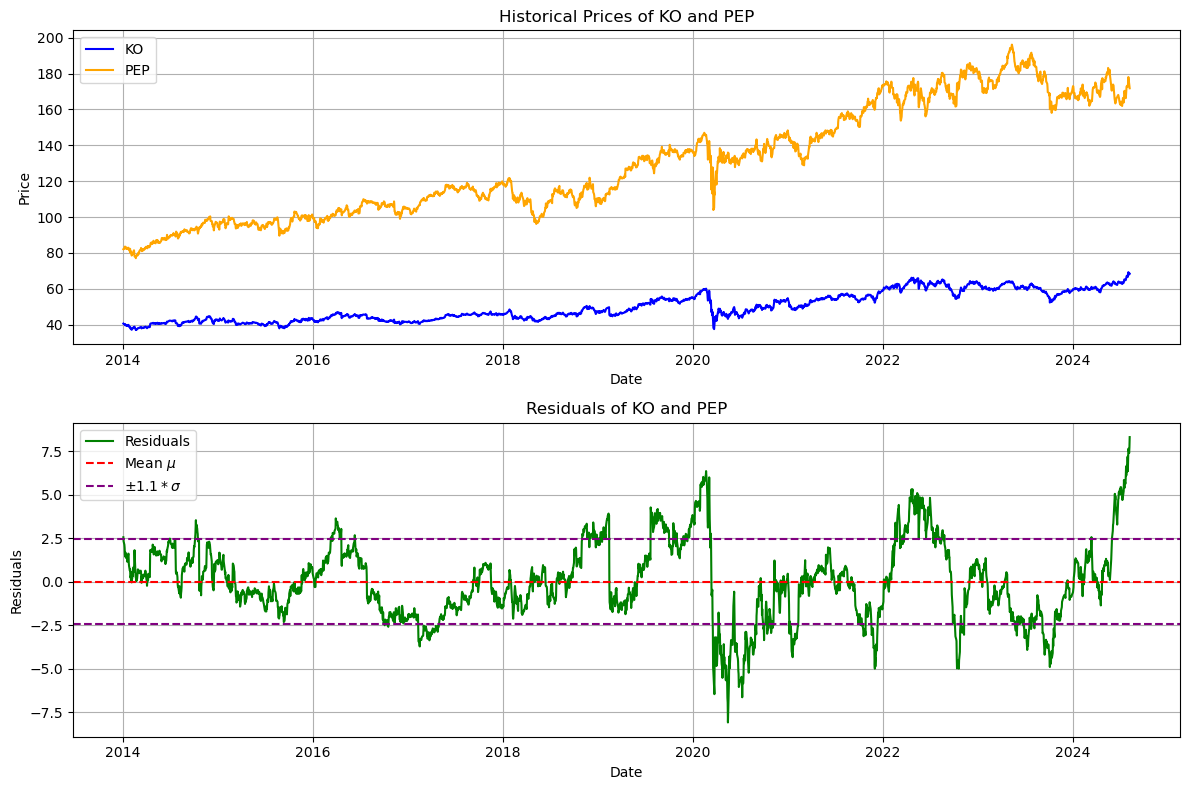

In [10]:
def plot_assets_and_residuals(data, ticker1, ticker2):
    plt.figure(figsize=(12, 8))

    # price time series plot
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data[ticker1], label=f"{ticker1}", color="blue")
    plt.plot(data.index, data[ticker2], label=f"{ticker2}", color="orange")
    plt.title(f"Historical Prices of {ticker1} and {ticker2}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # residuals plot
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['residuals'], label="Residuals", color="green")
    mean = data['residuals'].mean()
    stdev = data['residuals'].std()
    plt.axhline(mean, color="red", linestyle='--', label=f"Mean $\mu$")
    plt.axhline(mean + 1.1 * stdev, color="purple", linestyle="--", label="$\pm1.1*\sigma$")
    plt.axhline(mean - 1.1 * stdev, color="purple", linestyle="--")
    plt.title(f"Residuals of {ticker1} and {ticker2}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_assets_and_residuals(data, ticker1, ticker2)

In [14]:
def perform_adf_test(residuals, significance_level):
    # Augmented Dickey-Fuller (ADF) test to check for the presence of unit root in a time series
    # H0: time series has a unit root (i.e. non-stationary)
    adf_test = adfuller(residuals)
    adf_statistic, p_value = adf_test[0], adf_test[1]

    print(f"ADF Statistic: {adf_statistic:2f}")
    print(f"p-value: {p_value:2f}")

    if p_value < significance_level:
        print(f"The residuals are stationary (reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    else:
        print(f"The residuals are not stationary (accept null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    return adf_test


adf_test_result = perform_adf_test(data['residuals'], significance_level=0.05)

ADF Statistic: -3.690750
p-value: 0.004245
The residuals are stationary (reject null hypothesis) at the 5.0% significance level.


### Conclusion for the example of KO and PEP
The p-value indicates that the time series of KO and PEP are not only cointegrated at 5% significance level, but even with at 1% significance level, since the ADF statistic value is -3.80.

## Step 2 of Engle-Granger: ECM

The ECM now considers the absolute returns (differences) $\Delta X_t = X_t - X_{t-1}$ (e.g., PEP) and $\Delta Y_t = Y_t - Y_{t-1}$ (e.g., KO). Considering such differences removes long-term continuous effects and is more suitable to analyze short-term dynamics.

The Equilibrium Correction Model (ECM) follows the equation
$$\Delta Y_t =\alpha_0+\alpha_1 \cdot \Delta X_t + \alpha_2\cdot u_{t-1}+\epsilon_t,$$
where
* $u_{t-1}$ denotes the lagged residuals from the previous cointegration regression.
* $\alpha=\left(\alpha_0, \alpha_1, \alpha_2\right)$ is the coefficient of the ECM regression. In particular, $\alpha_2$ is the error correction term coefficient of the residual term $u_{t-1}$, representing the speed of adjustment towards the long-term equilibrium.
* $\epsilon_t$ denotes the "new" residual terms, inferred from regressing the ECM.

In [15]:
def get_differences(data, columns):
    """
    Calculate the returns (differences) Delta y_t = y_t-y_{t-1} for the specified columns in the dataframe.

    Parameters:
    - data: pd.DataFrame, the original time series data
    - columns: list, the columns for which to calculate differences

    Returns:
    - data_diff: pd.DataFrame, the differences of the specified columns
    """
    return data[columns].diff().dropna()


def fit_ecm(data, residuals_column, target_column, independent_column):
    """
    Fit the Equilibrium Correction Model (ECM).

    Parameters:
    - data: pd.DataFrame, the original time series data including residuals
    - residuals_column: str, the column name for residuals
    - target_column: str, the dependent variable
    - independent_column: str, the independent variable

    Returns:
    - ecm_results: dict, the coefficients and residuals of the ECM.
    """
    data_delta = get_differences(data, [target_column, independent_column])
    data_delta['lagged_residuals'] = data[residuals_column].shift(1)  # lag the residuals

    data_delta = data_delta.dropna()

    # OLS to obtain ECM coefficients & residuals
    y = data_delta[target_column].values
    X = data_delta[[independent_column, "lagged_residuals"]].values
    ecm_coefficients, ecm_residuals = least_squares_regression(y, X)

    ecm_residuals = pd.DataFrame(ecm_residuals, index=data_delta.index, columns=["ECM_residuals"])  # convert to pd.df
    return {'coefficients': ecm_coefficients, 'residuals': ecm_residuals}


# Fit the ECM for KO and PEP
ecm_results = fit_ecm(data, "residuals", ticker1, ticker2)
print("ECM Coefficients:", ecm_results['coefficients'])
print("ECM Residuals:", ecm_results['residuals'])

ECM Coefficients: [ 0.00135304  0.26861535 -0.0121196 ]
ECM Residuals:             ECM_residuals
Date                     
2014-01-03      -0.207978
2014-01-06      -0.173956
2014-01-07      -0.177975
2014-01-08      -0.363287
2014-01-09      -0.087733
...                   ...
2024-08-01       0.680735
2024-08-02       0.626500
2024-08-05      -0.064286
2024-08-06       0.454621
2024-08-07       0.690308

[2666 rows x 1 columns]


### Conclusion for the example of KO and PEP

The ECM regression for the considered example can be formulated as
$$\Delta\text{KO}_t = \alpha_0 + \alpha_1 \Delta\text{PEP}_t + \alpha_2 u_{t-1} + \epsilon_t$$
with $\alpha = \left(\alpha_0, \alpha_1, \alpha_2\right) \approx \left(0.00, 0.27, -0.01\right)$.

#### Coefficients analysis

$\alpha_1$ is the coefficient that best describes the linear relationship between KO and PEP for shorter-term periods. It signifies that a unit change in $\Delta X_t = \Delta\text{PEP}_t$ results in a $\alpha_1\approx 0.27$ change in $\Delta Y_t = \Delta\text{KO}_t$.

The negative sign of $\alpha_2\approx -0.01$ indicates a mean-reversion towards the long-term mean since it signifies a tendency to correct deviations from the equilibrium.

#### Residuals comparison

While the previously calculated residuals $u_t$ represent deviations from the long-term equilibrium between KO and PEP, the ECM residual time series $\epsilon_t$ represent deviations in the changes of KO prices with respect to the changes in PEP prices, without the short-term and mean-reverting relationship were removed from the model.

Taking a closer look at the residuals, $\epsilon_t$ should expectedly be significantly lower in magnitude than the long-term equilibrium residuals $u_t$ and hover closely around $0$ without very obvious patterns - similar to white noise residuals, reflecting that the short-term dynamics and mean-reverting corrections to the long-term mean have already been accounted for.

Indeed a plot shows the described behavior:

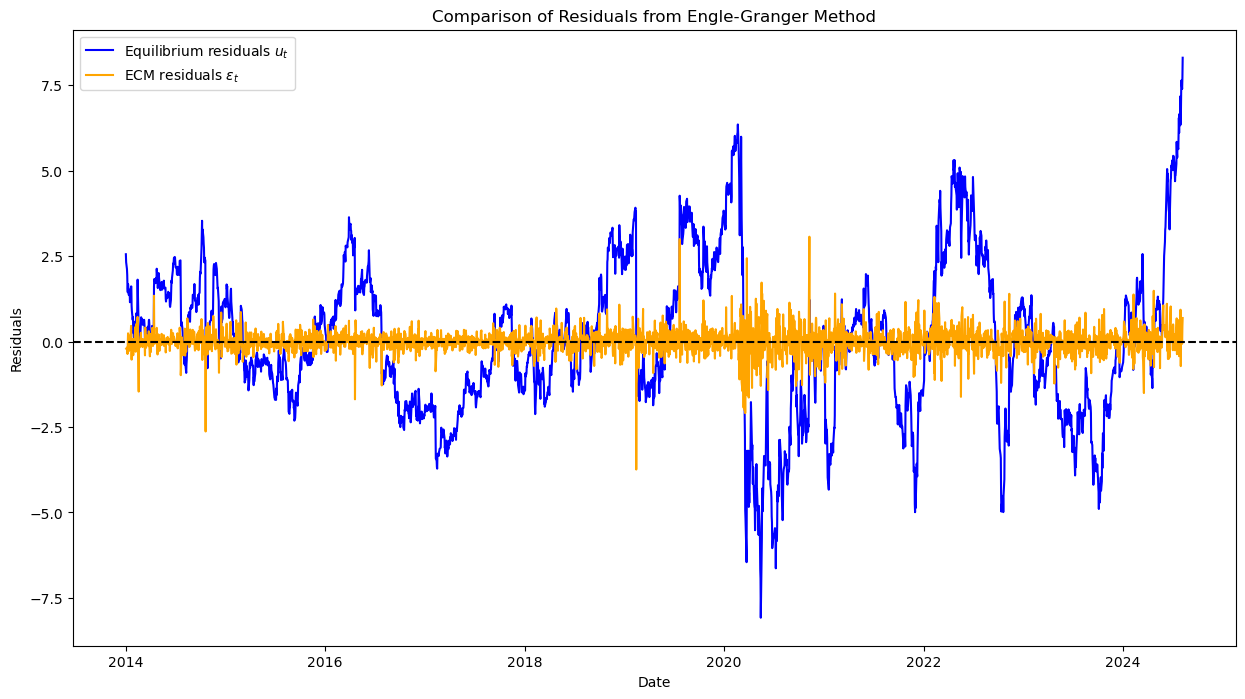

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(data.index, data['residuals'], label="Equilibrium residuals $u_t$", color="blue")
# Align indices for lagged epsilon residuals
plt.plot(data.index[1:], ecm_results['residuals'], label="ECM residuals $\epsilon_t$", color="orange")
plt.axhline(0, color='black', linestyle='--')
plt.title("Comparison of Residuals from Engle-Granger Method")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Trading strategy based on mean-reversion analysis

In [53]:
def backtest_pairs_trading(data, ticker1, ticker2, z):
    mean_residual = data['residuals'].mean()
    std_residual = data['residuals'].std()
    upper_bound = mean_residual + z * std_residual
    lower_bound = mean_residual - z * std_residual

    # Position Management explanation:
    # position = 1: long, position = -1: short, position = 0: flat
    position_ticker1 = 0
    position_ticker2 = 0
    entry_price_ticker1 = 0
    entry_price_ticker2 = 0
    pnl = []

    for index, row in data.iterrows():
        residual = row['residuals']

        if position_ticker1 == 0 and position_ticker2 == 0:
            if residual > upper_bound:  # spread between both tickers is very positive
                position_ticker1 = -1  # short ticker1 since over-valued from equilibrium
                position_ticker2 = 1  # long ticker2 since under-valued from equilibrium
                entry_price_ticker1 = row[ticker1]
                entry_price_ticker2 = row[ticker2]
            elif residual < lower_bound:  # spread between both tickers is very negative
                position_ticker1 = 1
                position_ticker2 = -1
                entry_price_ticker1 = row[ticker1]
                entry_price_ticker2 = row[ticker2]

        elif position_ticker1 == 1 and position_ticker2 == -1:  # Long ticker1, Short ticker2
            if residual >= mean_residual:
                pnl.append(
                    (row[ticker1] - entry_price_ticker1) + (entry_price_ticker2 - row[ticker2]))  # Close positions
                position_ticker1 = 0
                position_ticker2 = 0

        elif position_ticker1 == -1 and position_ticker2 == 1:  # Short ticker1, Long ticker2
            if residual <= mean_residual:
                pnl.append(
                    (entry_price_ticker1 - row[ticker1]) + (row[ticker2] - entry_price_ticker2))  # Close positions
                position_ticker1 = 0
                position_ticker2 = 0

    return np.sum(pnl)


def evaluate_pairs_trading_strategy(data, ticker1, ticker2):
    # Test different Z values and select the best one
    results = []
    for z in np.arange(0.5, 2.5, 0.1):
        pnl = backtest_pairs_trading(data, ticker1, ticker2, z)
        results.append({'Z': z, 'PnL': pnl})
    return pd.DataFrame(results)


pnl_table = evaluate_pairs_trading_strategy(data, ticker1, ticker2)

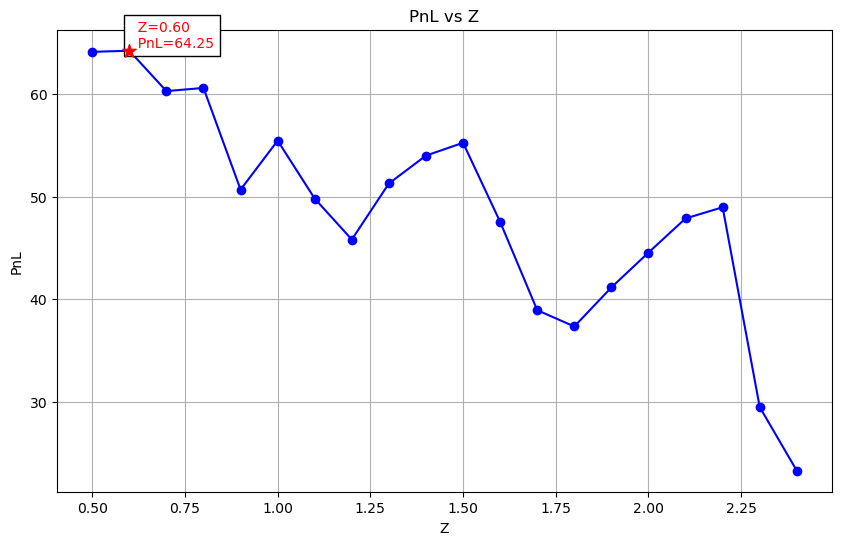

In [54]:
def find_best_pnl(pnl_df):
    # find the best PnL value and its corresponding Z
    best_row = pnl_df.loc[pnl_df['PnL'].idxmax()]
    return best_row['Z'], best_row['PnL']


plt.figure(figsize=(10, 6))
plt.plot(pnl_df['Z'], pnl_df['PnL'], marker="o", linestyle="-", color="b", label="PnL vs Z")

# Highlight the best PnL point with a star
best_z, best_pnl = find_best_pnl(pnl_df)
plt.scatter(best_z, best_pnl, color='r', marker="*", s=100, zorder=5,
            label=f"Best PnL: {best_pnl:.2f} at Z={best_z:.2f}")

# Add text annotation to best PnL
plt.text(best_z, best_pnl, f"  Z={best_z:.2f}\n  PnL={best_pnl:.2f}",
         color="r", verticalalignment="bottom", horizontalalignment="left",
         fontsize=10, bbox=dict(facecolor="white"))

plt.title("PnL vs Z")
plt.xlabel("Z")
plt.ylabel("PnL")
plt.grid(True)
plt.show()